In [1]:
!pip install pandas matplotlib 

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np 
import pandas as pd 
# fix this
#from src.dataset.util import read_jsonl, write_jsonl # need __init__.py file in 'dataset' ? 
import json
import os
import matplotlib.pyplot as plt

/tmp/ipykernel_3459/4111335835.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def read_jsonl(path: str) -> list[dict]:
    """
    """
    with open(path, "r") as jsonl_file:
        object = [json.loads(line.strip()) for line in jsonl_file]
    return object


def write_jsonl(object: list[dict], path: str) -> None:
    """
    """
    with open(path, "w") as jsonl_file:
        for data_dict in object:
            # Write each dictionary as a separate line in the jsonl file
            jsonl_file.write(json.dumps(data_dict) + "\n")

In [4]:
# read json file with publications
embs = read_jsonl('../data/interim/publications_parsed.ndjson')

# read in metadata from 'processed' folder
PROCESSED_PATH = '../data/processed/'
meta = pd.read_csv(os.path.join(PROCESSED_PATH, 'meta_publications_months.csv'), sep=';')

In [6]:
# add publication ID to merge the metadata and data
embs_df = pd.DataFrame(embs).drop(columns=['pub_date'])
embs_df.head()

,title,authors,abstract,sections,references,figures,formulas,doi,path,pub_id
0,Personal Spin D,Uta Frith,,"[{'heading': '', 'text': 'I was familiar with ...",[],"[{'figure_label': '', 'figure_type': 'table', ...",[],,data/raw/publications_manual_export/UTA public...,p1
1,Dimensional or Categorical Approaches to Autis...,Francesca Happé; Uta Frith; J Bralten; K J Van...,,"[{'heading': '', 'text': 'We are grateful for ...",[{'title': 'Autism spectrum disorders and auti...,[],[],10.1007/s10803-020-04728-5,data/raw/publications_manual_export/UTA public...,p2
2,,Uta Frith; H Asperger; U Frith; S Baron-Cohen;...,,"[{'heading': '', 'text': 'Uta Frith began her ...",[{'title': 'Die 'autistischen psychopathen' im...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p3
3,Autistic adolescents show atypical activation ...,Sarah J White; Uta Frith; Julian Rellecke; Zai...,Some autistic children pass classic Theory of ...,"[{'heading': 'Introduction', 'text': 'One of t...",[{'title': 'Prevalence of disorders of the aut...,"[{'figure_label': '1', 'figure_type': '', 'fig...",[],10.1016/j.neuropsychologia.2013.12.013,data/raw/publications_manual_export/UTA public...,p4
4,,Uta Frith,One contribution of 16 to a discussion meeting...,"[{'heading': '', 'text': 'Depression, schizoph...",[],[],[],10.1098/rstb.2017.0361,data/raw/publications_manual_export/UTA public...,p5


In [7]:
# add publication date column
dates = []
for i, row in meta.iterrows():
    year_month = f"{int(row['year'])}-{int(row['month'])}-01"
    pub_date = pd.to_datetime(year_month, format='%Y-%m-%d')
    dates.append(pub_date)

meta['date'] = dates
meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   pub_id  272 non-null    object        
 1   path    272 non-null    object        
 2   doi     142 non-null    object        
 3   source  272 non-null    object        
 4   year    272 non-null    float64       
 5   month   272 non-null    int64         
 6   date    272 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 15.0+ KB


In [8]:
# only include publications with quality data
quality = pd.read_csv(os.path.join(PROCESSED_PATH, 'meta_publications_quality.csv'))
# clean up quality
rows_to_include = []
for i, group in quality.groupby('pub_id'):
    # pick the pub_id with high n_characters
    top_row_in_grp = group['n_characters'].idxmax()
    rows_to_include.append(top_row_in_grp)

quality_short = quality.loc[rows_to_include]
quality_short.drop(columns=['Unnamed: 0', 'year', 'date', 'title', 'source'], inplace=True)
quality_short.reset_index(drop=True, inplace=True)

In [9]:
# merge embeddings with metadata
df = embs_df.merge(meta[['pub_id', 'year', 'source', 'date']], on='pub_id', how='left')
df = df.merge(quality_short, on='pub_id', how='left')
# sort by date!
df = df.sort_values('date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 272 entries, 188 to 271
Data columns (total 90 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   title                                   272 non-null    object        
 1   authors                                 272 non-null    object        
 2   abstract                                272 non-null    object        
 3   sections                                272 non-null    object        
 4   references                              272 non-null    object        
 5   figures                                 272 non-null    object        
 6   formulas                                272 non-null    object        
 7   doi_x                                   272 non-null    object        
 8   path_x                                  272 non-null    object        
 9   pub_id                                  272 non-null    o

In [40]:
# only include relevant columns, first 13 columns
df_subset = df.iloc[:, 0:13]
df_reset = df_subset.reset_index(drop=True)
df_reset.head()

,title,authors,abstract,sections,references,figures,formulas,doi_x,path_x,pub_id,year,source,date
0,Social communication and its disorder in autis...,Uta F R I T H; H Asperger; U Frith; A J Bailey...,Autism is a devastating developmental disorder...,"[{'heading': '', 'text': 'early part of the ce...",[{'title': 'Diagnostic and statistical manual ...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p189,1969.0,parsing,1969-01-01
1,Recent e x p e r i m e n t s o n autistic chil...,U Ta Frith L O N D O N; © Gordon; B Hermelin; ...,THe ArEas of cognition and social skills proba...,"[{'heading': '', 'text': 'research is taking t...",[{'title': 'autism: can autistic children make...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p190,1969.0,parsing,1969-09-01
2,Cognitive explanations of autism,U Frith; L Capps; N Yirmiya; M Sigman; A J Bai...,A brief review of the theory of mind account o...,"[{'heading': '', 'text': 'Initially, these pio...",[{'title': 'Understanding of simple and comple...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p187,1970.0,parsing,1970-01-01
3,Intrusion of orthographic knowledge on p h o n...,Karin Landerl; Heinz Wimmer; D R E S S F O R C...,In three typical phonological awareness tasks ...,"[{'heading': '', 'text': 'whether such a close...",[{'title': 'Proto-literate knowledge: Antecede...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p186,1970.0,parsing,1970-06-01
4,,Francesca Happé; Stefan Ehlers; Paul Fletcher;...,T H E ability t o attribute mental states to o...,"[{'heading': '', 'text': 'C A , + Correspondin...",[],"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p188,1970.0,parsing,1970-08-01


In [41]:
df_reset[df_reset['year'].isna()]

,title,authors,abstract,sections,references,figures,formulas,doi_x,path_x,pub_id,year,source,date
271,Animated triangles: An eye tracking investigation,Annette M Klein; Jan Zwickel; Wolfgang Prinz; ...,"This article may be used for research, teachin...","[{'heading': '', 'text': 'In their classic wor...",[{'title': 'Do triangles play tricks? Attribut...,"[{'figure_label': '1', 'figure_type': '', 'fig...",[],10.1080/17470210802384214,data/raw/publications_manual_export/UTA public...,p272,NaN,NaN,NaT


In [42]:
df_reset = df_reset.drop(271)

The 'sections' column in the dataframe contains a list all the sections in the paper (as dicts). 

In [43]:
# look at the second section in the second paper
df_reset['sections'][1][1]

{'heading': 'METHODOLOGICAL ASPECTS OF EXPERIMENTS IN AUTISM',
 'text': 'First, i t i s a well-known fact that handicapped children perform less well than non-handicapped ones on almost any psychological task one can think of. Thus, impaired performance may simply reflect a general impairment, whatever its cause. The effect of such a "general deficit" is shown both by mentally retarded autistic and mentally retarded non-autistic children. It is, not surprisingly, the consequence of not being well, i n a most general sense. What this means is that an observer may be quite misled about the behaviour of autistic children. He may be struck b y something that appears t o hi m t o be a glaring anomaly. However, such an anomaly may not necessarily be attributable to Autism. Certain observed peculiarities are peculiar only by c o m p a r i s o n with normal children o f the same age, but in fact are shared by all retarded children of the same mental age. It is only those peculiarities that r e

Above is an example of dict with the paper section, containing the heading and text. We want to go through each of the section headings and look for the word 'method', in order to count the number of papers that contain section headings.

In [44]:
# word to look for
word = 'method'

# initialize empty list
methods_binary = []

# go over each row (=paper) in the dataframe
for i in range(len(df_reset)):

    section = df_reset['sections'][i]

    headings_list = []

    # go through each section of that paper
    for i in range(len(section)):
        # save heading name and convert to lowercase
        headings = section[i]['heading'].lower()
        # append heading name to list of headings for that paper
        headings_list.append(headings)

    #matching = [s for s in headings_list if word in s]
    #print(len(matching))
    #print(matching)

    # if any version of 'method' is in the heading (i.e., also 'methods' and 'methodlogy', for example)
    if any(word in s for s in headings_list):
        methods_binary.append('yes')

    else:
        methods_binary.append('no')

In [45]:
# add list as column
df_reset['methods_section'] = methods_binary

In [46]:
# convert years to integers instead of floats
df_reset['year'] = df_reset['year'].astype(int)

In [47]:
df_reset.head()

,title,authors,abstract,sections,references,figures,formulas,doi_x,path_x,pub_id,year,source,date,methods_section
0,Social communication and its disorder in autis...,Uta F R I T H; H Asperger; U Frith; A J Bailey...,Autism is a devastating developmental disorder...,"[{'heading': '', 'text': 'early part of the ce...",[{'title': 'Diagnostic and statistical manual ...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p189,1969,parsing,1969-01-01,no
1,Recent e x p e r i m e n t s o n autistic chil...,U Ta Frith L O N D O N; © Gordon; B Hermelin; ...,THe ArEas of cognition and social skills proba...,"[{'heading': '', 'text': 'research is taking t...",[{'title': 'autism: can autistic children make...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p190,1969,parsing,1969-09-01,yes
2,Cognitive explanations of autism,U Frith; L Capps; N Yirmiya; M Sigman; A J Bai...,A brief review of the theory of mind account o...,"[{'heading': '', 'text': 'Initially, these pio...",[{'title': 'Understanding of simple and comple...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p187,1970,parsing,1970-01-01,no
3,Intrusion of orthographic knowledge on p h o n...,Karin Landerl; Heinz Wimmer; D R E S S F O R C...,In three typical phonological awareness tasks ...,"[{'heading': '', 'text': 'whether such a close...",[{'title': 'Proto-literate knowledge: Antecede...,"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p186,1970,parsing,1970-06-01,yes
4,,Francesca Happé; Stefan Ehlers; Paul Fletcher;...,T H E ability t o attribute mental states to o...,"[{'heading': '', 'text': 'C A , + Correspondin...",[],"[{'figure_label': '', 'figure_type': '', 'figu...",[],,data/raw/publications_manual_export/UTA public...,p188,1970,parsing,1970-08-01,no


In [48]:
# pivot df to count number of papers with and without methods sections for each year
methods_per_year = df_reset.pivot_table(index='year', columns='methods_section', aggfunc='size', fill_value=0)

# count total number of publications per year
grouped = df_reset.groupby('year').size()
methods_per_year['publications'] = grouped

# calculate the ratio of papers with methods sections compared to total number of papers per year
methods_per_year['methods_ratio'] = methods_per_year['yes'] / methods_per_year['publications']
methods_per_year.head()

methods_section,no,yes,publications,methods_ratio
year,,,,
1969,1,1,2,0.500000
1970,2,1,3,0.333333
1971,3,0,3,0.000000
1972,2,1,3,0.333333
1973,2,2,4,0.500000


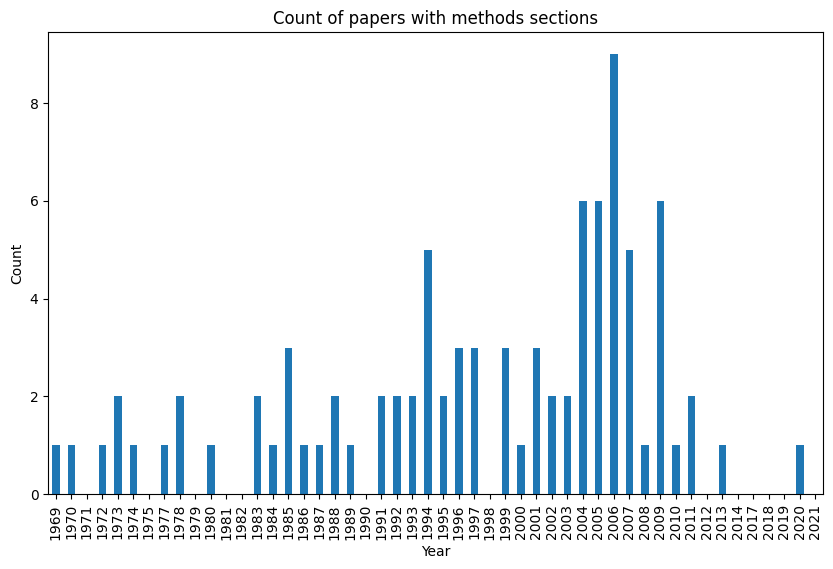

In [49]:
# plot raw count of papers with methods sections
methods_per_year['yes'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of papers with methods sections')
plt.show()

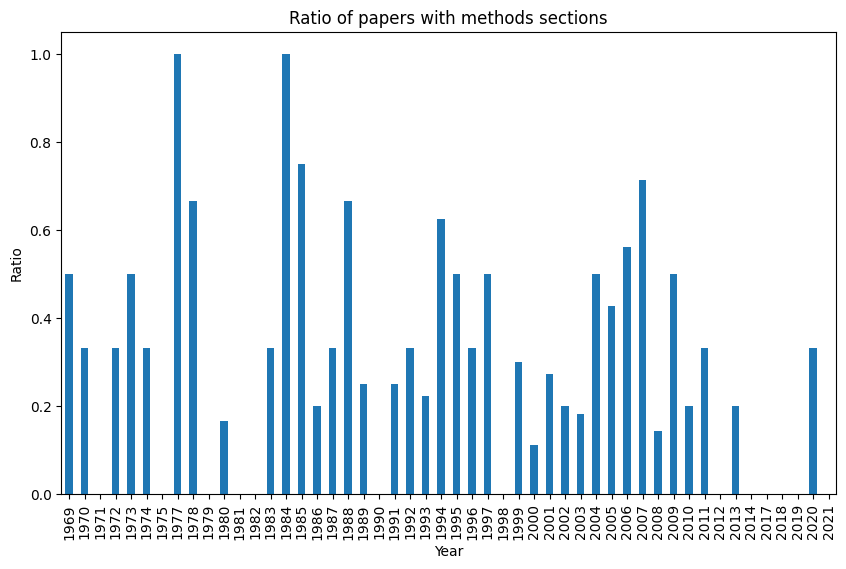

In [50]:
# plot ratio of papers with methods sections
methods_per_year['methods_ratio'].plot(kind='bar', figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Ratio of papers with methods sections')
plt.show()